In [33]:
#!/usr/bin/env python
# coding: utf-8

# In[9]:


# === Cell 1: imports & config ===
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.cosmology import Planck18 as cosmo
from astropy import constants as const

try:
    import py21cmfast as p21
except Exception as e:
    raise RuntimeError("py21cmfast is required for these plots.") from e

# --- physical constants (cgs), consistent with secondrun.py ---
sigma_T = const.sigma_T.cgs.value       # [cm^2]
MPC_CM  = 3.0856775814913673e24         # [cm]

# --- box and redshift grid ---
HII_DIM = 64     # pixels per side
BOX_LEN = 200.0  # Mpc (comoving)
ZS       = [16.0, 15.5, 15.0, 14.5, 14.0, 13.5, 13.0, 12.5, 12.0, 11.5, 11.0, 10.5, 10.0, 9.5, 9.0, 8.5, 8.0, 7.5, 7.0, 6.5, 6.0, 5.5, 5.0, 4.5, 4.0]  # tweak freely (strictly decreasing helps some routines)

voxel = BOX_LEN / HII_DIM
BOX_LABEL = f"Box: {BOX_LEN:.0f} Mpc, {HII_DIM}^3 (Δx={voxel:.2f} Mpc)"
print(BOX_LABEL, "\nzs =", ZS)


# In[11]:


Box: 200 Mpc, 64^3 (Δx=3.12 Mpc) 
zs = [16.0, 15.5, 15.0, 14.5, 14.0, 13.5, 13.0, 12.5, 12.0, 11.5, 11.0, 10.5, 10.0, 9.5, 9.0, 8.5, 8.0, 7.5, 7.0, 6.5, 6.0, 5.5, 5.0, 4.5, 4.0]


In [34]:
 #=== Cell 2: helpers (from secondrun.py style) ===

def ne0_cgs(Y_He=0.24, include_He=True):
    """Mean electron density today [cm^-3], including singly-ionized He if include_He."""
    m_p    = const.m_p.cgs.value
    rho_c0 = cosmo.critical_density0.cgs.value
    Om_b   = cosmo.Ob0
    n_b0   = (Om_b * rho_c0) / m_p
    X_H    = 1.0 - Y_He
    n_H0   = X_H * n_b0
    if include_He:
        y = Y_He / (4.0 * X_H)  # He/H by number
        electrons_per_H = 1.0 + y  # H (1) + singly ionized He (1)
    else:
        electrons_per_H = 1.0
    return n_H0 * electrons_per_H

ne0 = ne0_cgs()
print("n_e0 [cm^-3] =", ne0)

# ----- Replace your existing run_coeval_fields with this version -----
def run_coeval_fields(z, HII_DIM=HII_DIM, BOX_LEN=BOX_LEN, user_overrides=None, astro_overrides=None):
    """
    Run a 21cmFAST coeval box and return needed fields.
    astro_overrides: optional dict forwarded into astro_params for p21.run_coeval,
                    e.g. {"HII_EFF_FACTOR": 50.0}.
    """
    user_params = {"HII_DIM": int(HII_DIM), "BOX_LEN": float(BOX_LEN)}
    if user_overrides:
        # merge, allowing overrides
        user_params.update(user_overrides)

    astro_params = {}
    if astro_overrides:
        astro_params.update(astro_overrides)

    coeval = p21.run_coeval(
        redshift=float(z),
        user_params=user_params,
        astro_params=astro_params,
        write=False,
    )
    delta  = coeval.density               # matter overdensity δ (dimensionless)
    xH     = coeval.xH_box                # neutral fraction
    chi    = 1.0 - xH                     # ionized fraction χ
    vx     = coeval.lowres_vx * 1e5       # km/s -> cm/s
    vy     = coeval.lowres_vy * 1e5
    vz     = coeval.lowres_vz * 1e5
    return delta, chi, vx, vy, vz
# --------------------------------------------------------------------



def build_momentum(delta, chi, vx, vy, vz, z):
    """Physical ionized momentum q = n_e v, with n_e = ne0 * (1+z)^3 * (1+δ) χ."""
    ne_fluct = ne0 * (1.0 + z)**3 * (1.0 + delta) * chi  # cm⁻³
    qx = ne_fluct * vx  # cm⁻² s⁻¹
    qy = ne_fluct * vy  # cm⁻² s⁻¹
    qz = ne_fluct * vz  # cm⁻² s⁻¹
    print(f"z passed: {z}")
    print(qx.max()) # sanity check  
    return qx, qy, qz

def central_slice(arr):
    """Take central x-slice (ix=N//2) -> [N, N] panel."""
    N = arr.shape[0]
    return arr[N//2, :, :]

def title_with_box(base, z):
    return f"{base} (z={z})\n{BOX_LABEL}"


# In[ ]:



n_e0 [cm^-3] = 2.0643566911920377e-07


In [ ]:
#Cell 3: loop over HII_EFF_FACTOR and z, plotting slices
ZS1 = [12.0]                     # redshifts you want
HII_EFF_values = [1.0, 10.0, 50.0]  # low to high efficiency

for z in ZS1:
    for effval in HII_EFF_values:
        # pass HII_EFF_FACTOR into the coeval run
        delta, chi, vx, vy, vz = run_coeval_fields(
            z,
            astro_overrides={"HII_EFF_FACTOR": effval}
        )
        qx, qy, qz = build_momentum(delta, chi, vx, vy, vz, z)

        # central slices (use ASCII variable names)
        delta_sl = central_slice(delta)
        chi_sl   = central_slice(chi)
        vx_sl    = central_slice(vx)
        vy_sl    = central_slice(vy)
        vz_sl    = central_slice(vz)
        qx_sl    = central_slice(qx)
        qy_sl    = central_slice(qy)
        qz_sl    = central_slice(qz)

        vel_unit_label = "cm s$^{-1}$"

        # safe filename fragment for HII_EFF_FACTOR (no dots)
        effstr = str(effval).replace('.', 'p') if isinstance(effval, float) else str(effval)

        efflabel = f"{effval:.1e}"   # e.g. "3.0e+01"


        # figure: 2 rows x 4 cols
        fig, axs = plt.subplots(2, 4, figsize=(12, 6), constrained_layout=True)
        fig.suptitle(f"Real-space ingredients for Eq. (3) — z={z}, HII_EFF_FACTOR={efflabel}\n{BOX_LABEL}", fontsize=12)

        # Row 1: δ, v_x, v_y, v_z
        im = axs[0,0].imshow(delta_sl, origin="lower", cmap="RdBu", vmin=-1, vmax=1)
        plt.colorbar(im, ax=axs[0,0], pad=0.01, label="δ")
        axs[0,0].set_title("Density δ")

        im = axs[0,1].imshow(vx_sl, origin="lower", cmap="coolwarm")
        plt.colorbar(im, ax=axs[0,1], pad=0.01, label=f"v_x [{vel_unit_label}]")
        axs[0,1].set_title("v_x")

        im = axs[0,2].imshow(vy_sl, origin="lower", cmap="coolwarm")
        plt.colorbar(im, ax=axs[0,2], pad=0.01, label=f"v_y [{vel_unit_label}]")
        axs[0,2].set_title("v_y")

        im = axs[0,3].imshow(vz_sl, origin="lower", cmap="coolwarm")
        plt.colorbar(im, ax=axs[0,3], pad=0.01, label=f"v_z [{vel_unit_label}]")
        axs[0,3].set_title("v_z")

        # Row 2: x_e, q_x, q_y, q_z
        im = axs[1,0].imshow(chi_sl, origin="lower", cmap="magma", vmin=0, vmax=1)
        plt.colorbar(im, ax=axs[1,0], pad=0.01, label="x_e")
        axs[1,0].set_title(r"Ionized fraction $x_e=\chi$")

        im = axs[1,1].imshow(qx_sl, origin="lower", cmap="viridis")
        plt.colorbar(im, ax=axs[1,1], pad=0.01, label="q_x [cm s$^{-1}$]")
        axs[1,1].set_title(r"$q_x=(1+\delta)\,x_e\,v_x$")

        im = axs[1,2].imshow(qy_sl, origin="lower", cmap="viridis")
        plt.colorbar(im, ax=axs[1,2], pad=0.01, label="q_y [cm s$^{-1}$]")
        axs[1,2].set_title(r"$q_y=(1+\delta)\,x_e\,v_y$")

        im = axs[1,3].imshow(qz_sl, origin="lower", cmap="viridis")
        plt.colorbar(im, ax=axs[1,3], pad=0.01, label="q_z [cm s$^{-1}$]")
        axs[1,3].set_title(r"$q_z=(1+\delta)\,x_e\,v_z$")

        # save with z and HII_EFF_FACTOR in the filename
        outname = f"slice_z{z}_HIIeff_{effstr}.png"
        plt.savefig(outname, dpi=200)
        plt.show()

        # quick summary line per z
        print(f"z={z}, HII_EFF_FACTOR={effval}:  <x_e> = {chi.mean():.3f} | δ min/max = {delta.min():.2f}/{delta.max():.2f}")


# In[ ]:


/home/swanith/miniconda3/envs/p21clean/lib/python3.10/site-packages/py21cmfast/_utils.py:400: UserWarning: The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
  warnings.warn(
/home/swanith/miniconda3/envs/p21clean/lib/python3.10/site-packages/py21cmfast/inputs.py:491: UserWarning: The USE_INTERPOLATION_TABLES setting has changed in v3.1.2 to be default True. You can likely ignore this warning, but if you relied onhaving USE_INTERPOLATION_TABLES=False by *default*, please set it explicitly. To silence this warning, set it explicitly to True. Thiswarning will be removed in v4.
  warnings.warn(


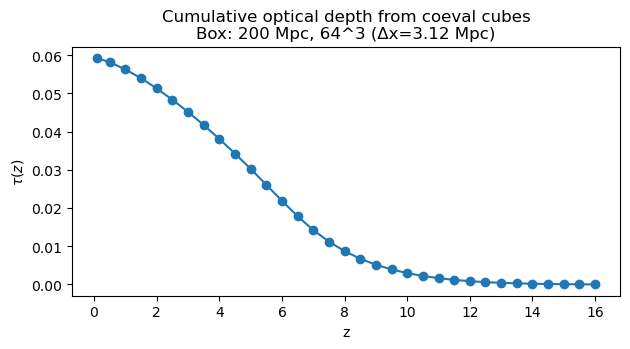

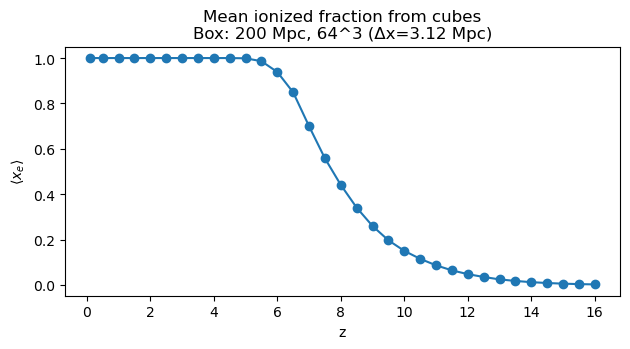

In [25]:
# === Cell 4: tau(z) and visibility from coeval cubes ===
# build z -> <x_e> from the same runs we used above
zs_arr = np.array(ZS, dtype=float)
chi_means = []
for z in zs_arr:
    _, chi, *_ = run_coeval_fields(z)
    chi_means.append(float(chi.mean()))
chi_means = np.array(chi_means)

# geometry
chis = np.array([cosmo.comoving_distance(z).value for z in zs_arr])  # [Mpc], increasing with z
# ensure we integrate from high z -> low z
order = np.argsort(zs_arr)[::-1]
zs_sorted   = zs_arr[order]
chis_sorted = chis[order]
xe_sorted   = chi_means[order]

# comoving bin widths (positive)
dchi = np.empty_like(chis_sorted)
dchi[:-1] = np.diff(chis_sorted)
dchi[-1]  = dchi[-2] if len(dchi) > 1 else 0.0
dchi = np.abs(dchi)  # [Mpc]

# accumulate tau from high->low z (τ=0 at highest z by convention)
tau = np.zeros_like(zs_sorted, dtype=float)
running = 0.0
for i in range(len(zs_sorted)-1):
    zmid  = 0.5*(zs_sorted[i] + zs_sorted[i+1])
    a_mid = 1.0/(1.0 + zmid)
    xe_mid = 0.5*(xe_sorted[i] + xe_sorted[i+1])
    dtaus = sigma_T * ne0 * xe_mid * (a_mid**-2) * (dchi[i] * MPC_CM)
    running += dtaus
    tau[i+1] = running

# restore original z order for plotting
unsort   = np.argsort(order)
tau_plot = tau[unsort]
zs_plot  = zs_arr

# --- plots ---
plt.figure(figsize=(6.4, 3.6))
plt.plot(zs_plot, tau_plot, marker='o')
plt.xlabel("z"); plt.ylabel(r"$\tau(z)$")
plt.title(f"Cumulative optical depth from coeval cubes\n{BOX_LABEL}")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6.4, 3.6))
plt.plot(zs_plot, chi_means, marker='o')
plt.xlabel("z"); plt.ylabel(r"$\langle x_e\rangle$")
plt.title(f"Mean ionized fraction from cubes\n{BOX_LABEL}")
plt.tight_layout()
plt.show()


# In[27]:


In [35]:
#== Cell 5a: q_perp FFT and power spectrum function ===

"""
Build q=(1+δ)χv, FFT to Q(k), project to Q_perp, estimate P_{q_perp}(k).

Args:
    delta, chi, vx, vy, vz : 3D numpy arrays (shape [N,N,N]) in real space
    BOX_LEN : float, box size in Mpc (comoving)
    nbins : int or None, number of k-bins (if None a heuristic is used)
    HII_EFF_FACTOR : optional numeric label. Not used in computation,
            but returned for bookkeeping.

Returns:
    (k_bin (Mpc^-1), P_bin (cm^2 s^-2 Mpc^3),
    qperp_slice (real-space |q_perp| mid-slice),
    kplane_amp (|Q| mid-kz plane, fftshifted),
    kplane_amp_perp (|Q_perp| mid-kz plane, fftshifted),
    kx2d, ky2d (fftshifted, for plotting axes),
    HII_EFF_FACTOR)  # final element is exactly the input HII_EFF_FACTOR (for labels/filenames)
"""
"""
Robust q_perp FFT + binned power estimator.
Returns (kvals, pvals, qperp_slice, kplane_amp, kplane_amp_perp, kx2, ky2, HII_EFF_FACTOR)
"""
    
    # --- real-space q ---
def qperp_fft_and_power(delta, chi, vx, vy, vz, BOX_LEN, nbins=None, HII_EFF_FACTOR=None):
    # Add z as a parameter!
    
    # --- real-space q ---
    ne_fluct = (1.0 + delta) * chi  # ADD THIS
    qx = ne_fluct * vx
    qy = ne_fluct * vy
    qz = ne_fluct * vz

    # --- geometry ---
    N = qx.shape[0]
    L = float(BOX_LEN)          # Mpc (comoving)
    d = L / N                   # Mpc
    V = L**3                    # Mpc^3

    # --- k-grid (1/Mpc) ---
    kfreq = np.fft.fftfreq(N, d=d) * 2.0*np.pi  # radians per Mpc
    kx, ky, kz = np.meshgrid(kfreq, kfreq, kfreq, indexing="ij")
    k2 = kx*kx + ky*ky + kz*kz
    k = np.sqrt(k2)
    k2_safe = np.where(k2 == 0.0, np.inf, k2)   # avoid div0 at k=0

    # --- FFT with continuous-FT normalization (× voxel volume) ---
    Qx = np.fft.fftn(qx) * (d**3)
    Qy = np.fft.fftn(qy) * (d**3)
    Qz = np.fft.fftn(qz) * (d**3)

    # --- project to transverse: Q_perp = Q - khat (Q·khat) ---
    kdotQ_over_k2 = (Qx*kx + Qy*ky + Qz*kz) / k2_safe
    Qx_perp = Qx - kdotQ_over_k2 * kx
    Qy_perp = Qy - kdotQ_over_k2 * ky
    Qz_perp = Qz - kdotQ_over_k2 * kz

    # --- power estimator: P(k) = <|Q_perp|^2>/V ---
    Qperp2 = (np.abs(Qx_perp)**2 + np.abs(Qy_perp)**2 + np.abs(Qz_perp)**2)
    p_flat = (Qperp2 / V).ravel()
    k_flat = k.ravel()

    # --- radial binning in k ---
    if nbins is None:
        nbins = int(np.ceil(np.cbrt(N) * 8))
    nbins = max(2, int(nbins))

    # find positive, non-zero unique kfreqs
    unique_kfreqs = np.unique(np.abs(kfreq))
    pos_kfreqs = unique_kfreqs[unique_kfreqs > 0.0]
    if pos_kfreqs.size == 0:
        kmin = 1e-6
    else:
        kmin = pos_kfreqs.min()

    kmax = np.abs(kfreq).max() * np.sqrt(3.0)
    if kmax <= kmin:
        kmax = kmin * 10.0

    bins = np.geomspace(kmin, kmax, nbins)
    digit = np.digitize(k_flat, bins)

    kvals, pvals, counts = [], [], []
    for i in range(1, len(bins)):
        mask = digit == i
        if not np.any(mask):
            continue
        kvals.append(k_flat[mask].mean())
        pvals.append(p_flat[mask].mean())
        counts.append(int(mask.sum()))

    # --- optional visuals: real-space |q_perp| mid-slice, and k-plane amplitudes (fftshifted) ---
    qx_perp_r = np.fft.ifftn(Qx_perp) / (d**3)
    qy_perp_r = np.fft.ifftn(Qy_perp) / (d**3)
    qz_perp_r = np.fft.ifftn(Qz_perp) / (d**3)
    qperp_mag = np.sqrt(np.abs(qx_perp_r)**2 + np.abs(qy_perp_r)**2 + np.abs(qz_perp_r)**2).real

    mid = N//2
    qperp_slice = qperp_mag[mid, :, :]

    plane_Q      = (np.abs(Qx)**2 + np.abs(Qy)**2 + np.abs(Qz)**2)**0.5
    plane_Qperp  = (np.abs(Qx_perp)**2 + np.abs(Qy_perp)**2 + np.abs(Qz_perp)**2)**0.5
    kplane_amp       = np.fft.fftshift(plane_Q[:, :, mid])
    kplane_amp_perp  = np.fft.fftshift(plane_Qperp[:, :, mid])

    kx2 = np.fft.fftshift(kx[:, :, mid])
    ky2 = np.fft.fftshift(ky[:, :, mid])

    return (np.array(kvals), np.array(pvals),
            qperp_slice, kplane_amp, kplane_amp_perp, kx2, ky2, HII_EFF_FACTOR)


# In[28]:


In [ ]:
 #=== Cell 5b: Diagnostic loop: tune z_show and HII_EFF_values here ===
z_show = 16.0
HII_EFF_values = [1.0, 10.0, 50.0]   # low to high efficiency

import math

for effval in HII_EFF_values:
    print(f"\nRunning diagnostics at z={z_show}, HII_EFF_FACTOR={effval} ...")

    # 1) generate fields for this (z, HII_EFF_FACTOR)
    delta, chi, vx, vy, vz = run_coeval_fields(z_show, astro_overrides={"HII_EFF_FACTOR": effval})
    qx, qy, qz = build_momentum(delta, chi, vx, vy, vz, z_show)

    # 2) compute FFT / power / k-plane using your function
    kvals, Pbins, qperp_slice, kplane_amp, kplane_amp_perp, kx2, ky2, eff_used = qperp_fft_and_power(
        delta, chi, vx, vy, vz, BOX_LEN, nbins=None, HII_EFF_FACTOR=effval
    )

    # 3) rebuild mode-counts / centers to match estimator (same logic as function)
    N = delta.shape[0]
    L = BOX_LEN
    d = L / N
    kfreq = np.fft.fftfreq(N, d=d) * 2.0*np.pi
    # robust non-zero kfreqs
    nonzero_kfreqs = np.abs(np.unique(kfreq))
    nonzero_kfreqs = nonzero_kfreqs[nonzero_kfreqs > 0] if nonzero_kfreqs.size>1 else np.array([1e-6])
    kmin = nonzero_kfreqs.min()
    kmax = kfreq.max() * np.sqrt(3.0)
    nb = int(np.ceil(np.cbrt(N) * 8))
    bins = np.geomspace(kmin, kmax, nb)
    kxg, kyg, kzg = np.meshgrid(kfreq, kfreq, kfreq, indexing="ij")
    k3d = np.sqrt(kxg*kxg + kyg*kyg + kzg*kzg).ravel()
    digit = np.digitize(k3d, bins)

    centers = []
    counts = []
    for i in range(1, len(bins)):
        mask = digit == i
        if not np.any(mask):
            continue
        centers.append(k3d[mask].mean())
        counts.append(mask.sum())
    centers = np.array(centers)
    counts = np.array(counts)

    # 4) pretty HII_EFF_FACTOR label: coeff x 10^exp when necessary
    # 4) pretty HII_EFF_FACTOR label: coeff x 10^exp when necessary
    if eff_used is None:
        efflabel = "HII_EFF_FACTOR=?"
        fnamefrag = "HIIeff_unknown"
        exp = 0
    else:
        exp = int(math.floor(math.log10(eff_used))) if eff_used > 0 else 0
        coeff = eff_used / (10**exp) if eff_used > 0 else eff_used
        if abs(coeff - 1.0) < 1e-3:
            efflabel = fr"$10^{{{exp}}}$"
            fnamefrag = f"1e{exp}"
        else:
            efflabel = fr"${coeff:.1f}\times 10^{{{exp}}}$"
            # make filename-friendly frag like 3p0e8 -> 3p0e8
            fnamefrag = f"{coeff:.1f}e{exp}".replace('.', 'p')

            
print(f"Pbins max for z={z_show}, eff={effval}: {Pbins.max()}") # sanity check
    # -----------------------
    # (B) k-space mid-kz plane (|Q_perp|)
    # -----------------------
    
    #plt.figure(figsize=(6.2,5.2))
    #im = plt.imshow(kplane_amp_perp, origin="lower", cmap="magma", norm=LogNorm(),
    #                extent=[kx2.min(), kx2.max(), ky2.min(), ky2.max()], aspect="equal")
    #plt.colorbar(im, pad=0.01, label=r"$|Q_\perp(k_x,k_y,k_z{=}0)|$")
    #plt.xlabel(r"$k_x$ [Mpc$^{-1}$]"); plt.ylabel(r"$k_y$ [Mpc$^{-1}$]")
    #plt.title(f"k-plane amplitude of $Q_\\perp$ (z={z_show}, HII_EFF_FACTOR={efflabel})\nBox: {L} Mpc, N={N} (Δx={d:.2f} Mpc)")
    #outname_kplane = f"q_perp_mid_kz_z{z_show}_HIIeff_{fnamefrag}.png"
    #plt.tight_layout(); plt.savefig(outname_kplane, dpi=200); plt.show(); plt.close()

    # -----------------------
    # (C) radial shell counts in k
    # -----------------------
    
    #plt.figure(figsize=(6.0,4.2))
    #plt.loglog(centers, counts, marker="o", ls="none")
    #plt.xlabel(r"$k$ [Mpc$^{-1}$]"); plt.ylabel("modes per shell")
    #plt.title(f"Radial shell counts in k (z={z_show}, HII_EFF_FACTOR={efflabel})\nBox: {L} Mpc, N={N}")
    #outname_counts = f"number_of_modes_in_bins_z{z_show}_HIIeff_{fnamefrag}.png"
    #plt.tight_layout(); plt.savefig(outname_counts, dpi=200); plt.show(); plt.close()

    # -----------------------
    # (D) binned power spectrum
    # -----------------------
    
    #plt.figure(figsize=(6.2,4.6))
    #plt.loglog(kvals, Pbins, lw=2, marker='o')
    #plt.xlabel(r"$k$ [Mpc$^{-1}$]"); plt.ylabel(r"$P_{q_\perp}(k)$ [cm$^2$ s$^{-2}$ Mpc$^3$]")
    #plt.title(f"$P_{{q_\\perp}}(k)$ at z={z_show}, HII_EFF_FACTOR={efflabel}\nBox: {L} Mpc, N={N}")
    #outname_pk = f"P_q_perp_z{z_show}_HIIeff_{fnamefrag}.png"
    #plt.tight_layout(); plt.savefig(outname_pk, dpi=200); plt.show(); plt.close()

    #print(f"Saved diagnostics: {outname_kplane}, {outname_counts}, {outname_pk}")


# In[29]:




Running diagnostics at z=16.0, HII_EFF_FACTOR=1.0 ...


/home/swanith/miniconda3/envs/p21clean/lib/python3.10/site-packages/py21cmfast/_utils.py:400: UserWarning: The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
  warnings.warn(
/home/swanith/miniconda3/envs/p21clean/lib/python3.10/site-packages/py21cmfast/inputs.py:491: UserWarning: The USE_INTERPOLATION_TABLES setting has changed in v3.1.2 to be default True. You can likely ignore this warning, but if you relied onhaving USE_INTERPOLATION_TABLES=False by *default*, please set it explicitly. To silence this warning, set it explicitly to True. Thiswarning will be removed in v4.
  warnings.warn(


z passed: 16.0
29.802265

Running diagnostics at z=16.0, HII_EFF_FACTOR=10.0 ...
z passed: 16.0
649.6423

Running diagnostics at z=16.0, HII_EFF_FACTOR=50.0 ...
z passed: 16.0
1952.9858
Pbins max for z=16.0, eff=50.0: 393968849033.54944



Processing HII_EFF_FACTOR = $10^{0}$ ...


/home/swanith/miniconda3/envs/p21clean/lib/python3.10/site-packages/py21cmfast/_utils.py:400: UserWarning: The following parameters to FlagOptions are not supported: ['USE_VELS_AUX']
  warnings.warn(
/home/swanith/miniconda3/envs/p21clean/lib/python3.10/site-packages/py21cmfast/inputs.py:491: UserWarning: The USE_INTERPOLATION_TABLES setting has changed in v3.1.2 to be default True. You can likely ignore this warning, but if you relied onhaving USE_INTERPOLATION_TABLES=False by *default*, please set it explicitly. To silence this warning, set it explicitly to True. Thiswarning will be removed in v4.
  warnings.warn(


  D_3000 (μK^2) ≈ 0.0005525  (cached as 1e0)

Processing HII_EFF_FACTOR = $10^{1}$ ...
  D_3000 (μK^2) ≈ 0.005743  (cached as 1e1)

Processing HII_EFF_FACTOR = $5.0\times 10^{1}$ ...
  D_3000 (μK^2) ≈ 0.01164  (cached as 5p0e1)


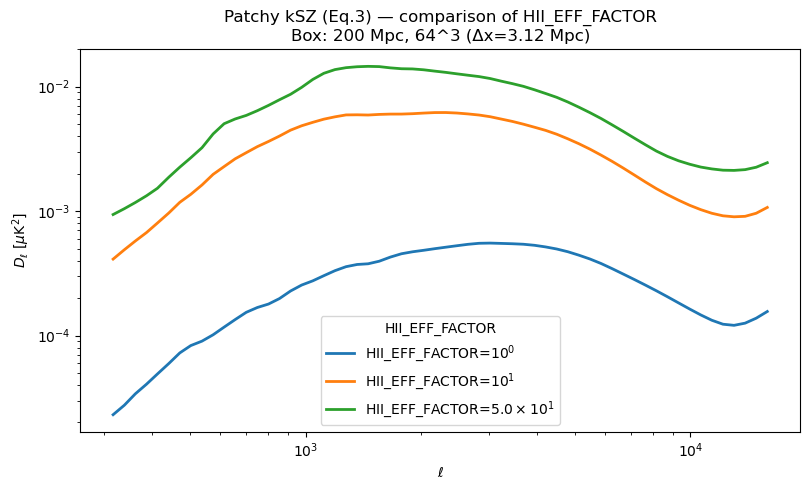

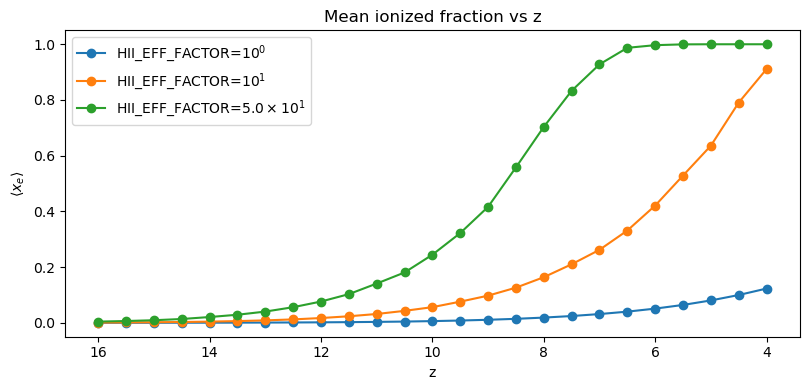

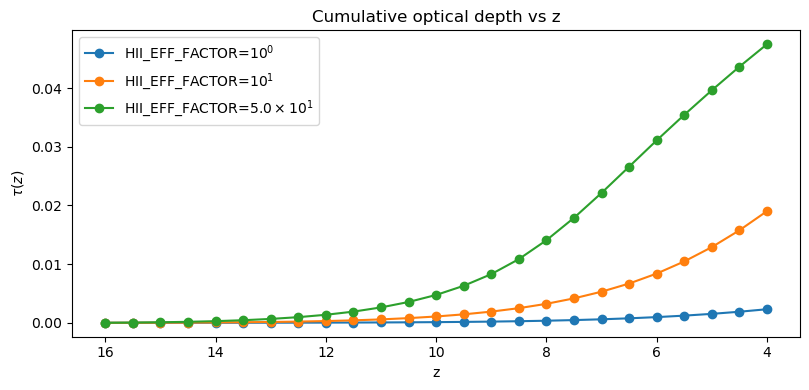

Done. Cached per-(z,HII_EFF_FACTOR) P(k) arrays in /home/swanith/Desktop/Project2/Plots/v3.3.1_Reion_Hist_Change/pq_cache


In [44]:
# ----------------------------
# Extended Cell 7: handle HII_EFF_FACTOR loops and plotting modes
# ----------------------------
import os
import math
from pathlib import Path
from scipy.interpolate import interp1d   # scipy usually available in these envs; if not, numpy.interp fallback below

cache_dir = Path("pk_cache")
cache_dir.mkdir(exist_ok=True)

# choose mode: "by_HIIeff" => per HII_EFF_FACTOR, plot P(k) across ZS
#             "by_z"     => per z, plot P(k) across HII_EFF_FACTOR
MODE = "by_z"   # change to "by_HIIeff" if you prefer
# pick HII_EFF_FACTOR values
HII_EFF_values = [1.0, 10.0, 50.0]

# common interpolation grid (log-spaced k) used when overlaying multiple curves
k_common = np.logspace(-3, 1, 200)   # adjust bounds/resolution if you like

# helper: pretty label and filename fragment from effval
def efflabel_and_frag(effval):
    if effval is None:
        return "HII_EFF_FACTOR=?", "HIIeff_unknown", 0
    exp = int(math.floor(math.log10(effval))) if effval > 0 else 0
    coeff = effval / (10**exp) if effval > 0 else effval
    if abs(coeff - 1.0) < 1e-3:
        label = fr"$10^{{{exp}}}$"
        frag  = f"1e{exp}"
    else:
        label = fr"${coeff:.1f}\times 10^{{{exp}}}$"
        frag  = f"{coeff:.1f}e{exp}".replace('.', 'p')
    return label, frag, exp

# caching + runner: compute (kbins, Pbins) for a given (z, effval)
def compute_or_load_pk(z, effval, force_rerun=True):
    label, frag, exp = efflabel_and_frag(effval)
    fname = cache_dir / f"pk_z{z}_HIIeff_{frag}.npz"
    if fname.exists() and not force_rerun:
        data = np.load(fname)
        return data["k"], data["P"], label, frag
    # run
    delta, chi, vx, vy, vz = run_coeval_fields(z, astro_overrides={"HII_EFF_FACTOR": effval})
    kbins, Pbins, *_ , eff_used = qperp_fft_and_power(delta, chi, vx, vy, vz, BOX_LEN, nbins=None, HII_EFF_FACTOR=effval)
    np.savez(fname, k=kbins, P=Pbins, eff=eff_used)
    return kbins, Pbins, label, frag

# -----------
# Mode A: per HII_EFF_FACTOR (plot P(k) for all z on one figure)
# -----------

#if MODE == "by_HIIeff":
#    for effval in HII_EFF_values:
#        plt.figure(figsize=(7.2,5.0))
#        label, frag, exp = efflabel_and_frag(effval)
#        for z in ZS:
#            kbins, Pbins, _, _ = compute_or_load_pk(z, effval)
#            # plot raw binned curve
#            plt.loglog(kbins, Pbins, label=f"z={z}")
#        plt.xlabel(r"$k$ [Mpc$^{-1}$]")
#        plt.ylabel(r"$P_{q_\perp}(k)$ [cm$^2$ s$^{-2}$ Mpc$^3$]")
#        plt.title(f"$P_{{q_\\perp}}(k)$ across redshift — HII_EFF_FACTOR={label}\n{BOX_LABEL}")
#        plt.legend(ncol=2, fontsize=8)
#        out = f"P_qperp_across_z_HIIeff_{frag}.png"
#        plt.tight_layout(); plt.savefig(out, dpi=200); plt.show()

# -----------
# Mode B: per z (plot P(k) for all HII_EFF_FACTOR on one figure) -- recommended for your use
# -----------

#elif MODE == "by_z":
#    for z in ZS:   # you can restrict to a subset if expensive (e.g. ZS1)
#        plt.figure(figsize=(7.2,5.0))
#       # gather curves for all HII_EFFs, interpolate to common k for clean overlay
#        curves = []
#        for effval in HII_EFF_values:
#            kbins, Pbins, label, frag = compute_or_load_pk(z, effval)
#            # use scipy interp if available (log-log interpolation)
#            try:
#                f_interp = interp1d(np.log(kbins), np.log(Pbins), bounds_error=False, fill_value=np.nan)
#                P_on_common = np.exp(f_interp(np.log(k_common)))
#            except Exception:
#                # fallback: linear interp in log-log using numpy.interp (extrap -> nan)
#                P_on_common = np.exp(np.interp(np.log(k_common), np.log(kbins), np.log(Pbins), left=np.nan, right=np.nan))
#            curves.append((effval, kbins, Pbins, P_on_common, label, frag))

        # plot each (use interpolated common grid)
#        for effval, kbins, Pbins, P_on_common, label, frag in curves:
#            plt.loglog(k_common, P_on_common, lw=1.8, label=f"HII_EFF_FACTOR={label}")

#        plt.xlabel(r"$k$ [Mpc$^{-1}$]")
#        plt.ylabel(r"$P_{q_\perp}(k)$ [cm$^2$ s$^{-2}$ Mpc$^3$]")
#        plt.title(f"$P_{{q_\\perp}}(k)$ at z={z} — comparison of HII_EFF_FACTOR\n{BOX_LABEL}")
#        plt.legend(title="HII_EFF_FACTOR", fontsize=9)
#        out = f"P_qperp_vs_HIIeff_z{z}.png"
#        plt.tight_layout(); plt.savefig(out, dpi=200); plt.show()

# -----------
# else: invalid mode
# -----------

#else:
#    raise ValueError("MODE must be 'by_HIIeff' or 'by_z'")

# ----------------------------
# End of extended Cell 6
# ----------------------------


# In[32]:


# ----------------------------
# Multi-HII_EFF_FACTOR PKSZ + <x_e>(z) + tau(z) pipeline (with caching)
# ----------------------------
import os, math
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

sigma_T = const.sigma_T.cgs.value    # Thomson cross-section [cm^2]
c_cms   = const.c.cgs.value          # speed of light [cm/s]
MPC_CM  = 3.0856775814913673e24      # 1 Mpc in cm
T_CMB_K = 2.7255                     # CMB temperature [K]
ne0     = ne0_cgs()                  # mean electron density today [cm^-3]


# user-tunable
HII_EFF_values = [1.0, 10.0, 50.0]   # low to high efficiency
ZS_run = np.array(ZS, dtype=float) # redshift grid to use (same as your notebook)
zsort_desc = np.argsort(-ZS_run)   # high -> low ordering used in Eq.(3)
cache_dir = Path("pq_cache")
cache_dir.mkdir(exist_ok=True)

# helper: pretty label and filename fragment from effval
def efflabel_and_frag(effval):
    if effval is None:
        return "HII_EFF_FACTOR=?", "HIIeff_unknown", 0
    exp = int(math.floor(math.log10(effval))) if effval>0 else 0
    coeff = effval / (10**exp) if effval>0 else effval
    if abs(coeff - 1.0) < 1e-3:
        label = fr"$10^{{{exp}}}$"
        frag  = f"1e{exp}"
    else:
        label = fr"${coeff:.1f}\times 10^{{{exp}}}$"
        frag  = f"{coeff:.1f}e{exp}".replace('.', 'p')
    return label, frag, exp

# re-use your interp_loglog if present; else define here
def interp_loglog(xq, xp, fp):
    xp = np.asarray(xp); fp = np.asarray(fp)
    m  = (xp > 0) & (fp > 0)
    lx = np.log(xp[m]); lf = np.log(fp[m])
    # clip query to xp range to avoid extrapolation issues
    lq = np.log(np.clip(xq, xp[m].min(), xp[m].max()))
    return np.exp(np.interp(lq, lx, lf, left=lf[0], right=lf[-1]))

# compute or load per-(z,eff) binned P(k); also cache mean x_e for that z
def compute_or_load_zm(z, effval, force=True):
    # cache file names
    _, frag, _ = efflabel_and_frag(effval)
    fname = cache_dir / f"pk_z{z}_HIIeff_{frag}.npz"
    if fname.exists() and not force:
        dat = np.load(fname)
        return dat["k"], dat["P"], float(dat["xe_mean"])
    # not cached: run coeval, compute P(k)
    delta, chi, vx, vy, vz = run_coeval_fields(z, astro_overrides={"HII_EFF_FACTOR": effval})
    # store mean xe for this cube
    xe_mean = float(chi.mean())
    # compute q-perp power (uses your function)
    kbins, Pbins, *_ , eff_used = qperp_fft_and_power(delta, chi, vx, vy, vz, BOX_LEN, nbins=None, HII_EFF_FACTOR=effval)
    np.savez(fname, k=kbins, P=Pbins, xe_mean=xe_mean, eff=eff_used)
    return kbins, Pbins, xe_mean

# geometry arrays (sorted high->low for integration)
chis = np.array([cosmo.comoving_distance(z).value for z in ZS_run])  # [Mpc] (increasing with z)
a_z   = 1.0/(1.0 + ZS_run)
# reorder high->low
ZS_sorted = ZS_run[zsort_desc]
chi_sorted = chis[zsort_desc]
a_sorted = a_z[zsort_desc]
# dchi (comoving widths) from geometry
dchi_sorted = np.empty_like(chi_sorted)
dchi_sorted[:-1] = np.diff(chi_sorted)
dchi_sorted[-1] = dchi_sorted[-2] if len(dchi_sorted)>1 else 0.0
dchi_sorted = np.abs(dchi_sorted)
ds_cm_sorted = dchi_sorted * MPC_CM

# ell grid (same as your block)
ells = np.unique(np.round(np.logspace(2.5, 4.2, 60))).astype(int)

# prefactor in Eq.(3)
pref = (sigma_T * ne0 / c_cms)**2

# containers for plotting and summary
Dell_dict = {}      # maps frag -> D_ell array
xe_by_m = {}        # maps frag -> (z_sorted, xe_sorted)
tau_by_m = {}       # maps frag -> (z_sorted, tau_sorted)

# MAIN loop over HII_EFF_values
for effval in HII_EFF_values:
    lab, frag, exp = efflabel_and_frag(effval)
    print(f"\nProcessing HII_EFF_FACTOR = {lab} ...")
    # collect per-z P(k) and xe means
    k_list = []
    P_list = []
    xe_means = []
    for z in ZS_sorted:                # NOTE: compute in high->low order (same for integration)
        kb, Pb, xe_mean = compute_or_load_zm(z, effval, force=True)# force_rerun=True to recompute all
        k_list.append(np.asarray(kb))
        P_list.append(np.asarray(Pb))
        xe_means.append(float(xe_mean))

    # store xe sorted by the same high->low z order
    xe_sorted = np.array(xe_means)
    xe_by_m[frag] = (ZS_sorted.copy(), xe_sorted.copy())

    # compute tau(z) integrated high->low using xe_sorted
    tau = np.zeros_like(ZS_sorted, dtype=float)
    running = 0.0
    for i in range(len(ZS_sorted)-1):
        zmid = 0.5*(ZS_sorted[i] + ZS_sorted[i+1])
        a_mid = 1.0/(1.0 + zmid)
        xe_mid = 0.5*(xe_sorted[i] + xe_sorted[i+1])
        dtaus = sigma_T * ne0 * xe_mid * (a_mid**-2) * (dchi_sorted[i] * MPC_CM)
        running += dtaus
        tau[i+1] = running
    tau_by_m[frag] = (ZS_sorted.copy(), tau.copy())

    # Eq.(3) accumulation: C_ell = pref * Σ_i [ e^{-2τ_i} / (s_i^2 a_i^4) * P(k = ℓ/s_i, z_i) * ds_i ]
    vis2_sorted = np.exp(-2.0 * tau)   # visibility
    C_ell = np.zeros_like(ells, dtype=float)
    for i in range(len(ZS_sorted)):
        s = chi_sorted[i]
        a = a_sorted[i]
        w = vis2_sorted[i] / (s**2 * a**4) * (dchi_sorted[i])
        k_now = ells / s   # ℓ / s [Mpc^-1]
        # interpolate P onto k_now using log-log interpolation (clip within kb range)
        P_now = interp_loglog(k_now, k_list[i], P_list[i])
        C_ell += pref * w * P_now * (MPC_CM**2)

    D_ell_uK2 = ells*(ells+1.0)/(2.0*np.pi) * C_ell * (T_CMB_K**2) * (1e6**2)
    Dell_dict[frag] = (ells.copy(), D_ell_uK2.copy())

    # quick print
    D3000 = float(np.interp(3000.0, ells, D_ell_uK2))
    print(f"  D_3000 (μK^2) ≈ {D3000:.4g}  (cached as {frag})")

# ----------------------------
# Now plotting: overlay D_ells, and show <x_e>(z), tau(z)
# ----------------------------
plt.figure(figsize=(8.2,5.0))
for effval in HII_EFF_values:
    lab, frag, exp = efflabel_and_frag(effval)
    ells_plot, Dell = Dell_dict[frag]
    plt.loglog(ells_plot, Dell, lw=2, label=f"HII_EFF_FACTOR={lab}")
plt.xlabel(r"$\ell$"); plt.ylabel(r"$D_\ell$ [$\mu$K$^2$]")
plt.title("Patchy kSZ (Eq.3) — comparison of HII_EFF_FACTOR\n" + BOX_LABEL)
plt.legend(title="HII_EFF_FACTOR")
plt.tight_layout()
plt.savefig("D_ell_overlay_HIIeff.png", dpi=200)
plt.show()

# plot <x_e>(z) for each HII_EFF_FACTOR
plt.figure(figsize=(8.2,4.0))
for effval in HII_EFF_values:
    _, frag, _ = efflabel_and_frag(effval)
    zs_plot, xe_plot = xe_by_m[frag]
    # restore to ascending redshift order for plotting convenience (low->high)
    order_plot = np.argsort(zs_plot)
    plt.plot(zs_plot[order_plot], xe_plot[order_plot], marker='o', label=f"HII_EFF_FACTOR={efflabel_and_frag(effval)[0]}")
plt.xlabel("z"); plt.ylabel(r"$\langle x_e \rangle$")
plt.title("Mean ionized fraction vs z")
plt.gca().invert_xaxis()  # optional: show high z on left
plt.legend(); plt.tight_layout(); plt.savefig("xe_vs_z_allHIIeff.png", dpi=200); plt.show()

# plot tau(z) for each HII_EFF_FACTOR
plt.figure(figsize=(8.2,4.0))
for effval in HII_EFF_values:
    _, frag, _ = efflabel_and_frag(effval)
    zs_plot, tau_plot = tau_by_m[frag]
    order_plot = np.argsort(zs_plot)
    plt.plot(zs_plot[order_plot], tau_plot[order_plot], marker='o', label=f"HII_EFF_FACTOR={efflabel_and_frag(effval)[0]}")
plt.xlabel("z"); plt.ylabel(r"$\tau(z)$")
plt.title("Cumulative optical depth vs z")
plt.gca().invert_xaxis()
plt.legend(); plt.tight_layout(); plt.savefig("tau_vs_z_allHIIeff.png", dpi=200); plt.show()

print("Done. Cached per-(z,HII_EFF_FACTOR) P(k) arrays in", cache_dir.resolve())


# In[ ]:


In [43]:
# geometry arrays (sorted high->low for integration)
chis = np.array([cosmo.comoving_distance(z).value for z in ZS_run])  # [Mpc] (increasing with z)
a_z = 1.0 / (1.0 + ZS_run)
# reorder high->low
ZS_sorted = ZS_run[zsort_desc]
chi_sorted = chis[zsort_desc]
a_sorted = a_z[zsort_desc]
# dchi (comoving widths) from geometry
dchi_sorted = np.empty_like(chi_sorted)
dchi_sorted[:-1] = np.diff(chi_sorted)
dchi_sorted[-1] = dchi_sorted[-2] if len(dchi_sorted) > 1 else 0.0
dchi_sorted = np.abs(dchi_sorted)
ds_cm_sorted = dchi_sorted * MPC_CM

# Print all values for debugging
print("pref:", pref)
print("ZS_sorted:", ZS_sorted)
print("chi_sorted [Mpc]:", chi_sorted)
print("a_sorted:", a_sorted)
print("dchi_sorted [Mpc]:", dchi_sorted)
print("ds_cm_sorted [cm]:", ds_cm_sorted)
print("P_now:", P_now)

pref: 2.0984201648676483e-83
ZS_sorted: [16.  15.5 15.  14.5 14.  13.5 13.  12.5 12.  11.5 11.  10.5 10.   9.5
  9.   8.5  8.   7.5  7.   6.5  6.   5.5  5.   4.5  4. ]
chi_sorted [Mpc]: [10571.24006799 10513.42702822 10452.92215832 10389.5102281
 10322.95113718 10252.97609724 10179.28307334 10101.53130864
 10019.33470655  9932.2537781   9839.78577238  9741.35248604
  9636.28507946  9523.804993    9402.99972551  9272.7917624
  9131.89825022  8978.77799176  8811.56079511  8627.95184124
  8425.10001493  8199.41316468  7946.29340367  7659.74888529
  7331.80946186]
a_sorted: [0.05882353 0.06060606 0.0625     0.06451613 0.06666667 0.06896552
 0.07142857 0.07407407 0.07692308 0.08       0.08333333 0.08695652
 0.09090909 0.0952381  0.1        0.10526316 0.11111111 0.11764706
 0.125      0.13333333 0.14285714 0.15384615 0.16666667 0.18181818
 0.2       ]
dchi_sorted [Mpc]: [ 57.81303977  60.5048699   63.41193023  66.55909092  69.97503994
  73.6930239   77.7517647   82.19660209  87.08092845  92.

Computing kSZ map contributions...
z=16.0: mean Delta T contribution = -0.000 uK
z=15.5: mean Delta T contribution = -0.000 uK
z=15.0: mean Delta T contribution = 0.000 uK
z=14.5: mean Delta T contribution = -0.000 uK
z=14.0: mean Delta T contribution = -0.001 uK
z=13.5: mean Delta T contribution = 0.000 uK
z=13.0: mean Delta T contribution = -0.000 uK
z=12.5: mean Delta T contribution = -0.000 uK
z=12.0: mean Delta T contribution = 0.000 uK
z=11.5: mean Delta T contribution = 0.001 uK
z=11.0: mean Delta T contribution = 0.000 uK
z=10.5: mean Delta T contribution = -0.001 uK
z=10.0: mean Delta T contribution = -0.002 uK
z=9.5: mean Delta T contribution = -0.000 uK
z=9.0: mean Delta T contribution = -0.001 uK
z=8.5: mean Delta T contribution = -0.001 uK
z=8.0: mean Delta T contribution = -0.001 uK
z=7.5: mean Delta T contribution = -0.001 uK
z=7.0: mean Delta T contribution = -0.000 uK
z=6.5: mean Delta T contribution = -0.001 uK
z=6.0: mean Delta T contribution = -0.002 uK
z=5.5: mean 

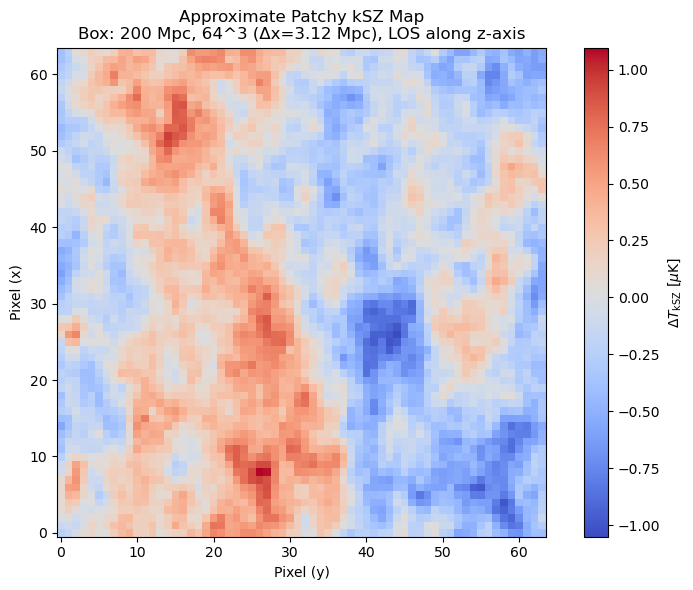

Done. Saved as ksz_map.png


In [ ]:
################kSZ map generation (approximate)################
# Assumes LOS along z-axis, and uses mean tau(z) for visibility
# Uses same ZS grid as your notebook
# Saves a 2D map (64x64 pixels) as ksz_map.png
import numpy as np
import matplotlib.pyplot as plt
from astropy import constants as const

T_CMB = 2.7255  # K

# Compute mean tau(z) as in Cell 4 (high to low z, cumulative)
zs_arr = np.array(ZS, dtype=float)
chi_means = []
for z in zs_arr:
    _, chi, *_ = run_coeval_fields(z)  # Add user_overrides={} if needed
    chi_means.append(float(chi.mean()))
chi_means = np.array(chi_means)

chis = np.array([cosmo.comoving_distance(z).value for z in zs_arr])  # Mpc
order = np.argsort(zs_arr)[::-1]  # High to low z
zs_sorted = zs_arr[order]
chis_sorted = chis[order]
xe_sorted = chi_means[order]

dchi = np.empty_like(chis_sorted)
dchi[:-1] = np.diff(chis_sorted)
dchi[-1] = dchi[-2] if len(dchi) > 1 else 0.0
dchi = np.abs(dchi)  # Mpc

tau_sorted = np.zeros_like(zs_sorted, dtype=float)
running = 0.0
for i in range(len(zs_sorted) - 1):
    zmid = 0.5 * (zs_sorted[i] + zs_sorted[i + 1])
    a_mid = 1.0 / (1.0 + zmid)
    xe_mid = 0.5 * (xe_sorted[i] + xe_sorted[i + 1])
    dtaus = sigma_T * ne0 * xe_mid * (a_mid ** -2) * (dchi[i] * MPC_CM)
    running += dtaus
    tau_sorted[i + 1] = running

# Map tau back to original z order for easy lookup
tau_dict = dict(zip(zs_sorted, tau_sorted))

# Voxel size in comoving cm
dvoxel_cm = (BOX_LEN / HII_DIM) * MPC_CM  # cm

# Initialize total kSZ map (64 x 64, assuming projection along z-axis)
ksz_map = np.zeros((HII_DIM, HII_DIM))  # in uK

print("Computing kSZ map contributions...")
for iz, z in enumerate(zs_arr):
    # Run coeval (add astro_overrides or user_overrides if needed, e.g., for HII_EFF_FACTOR)
    delta, chi, vx, vy, vz = run_coeval_fields(z)
    
    # Assume LOS along z: q_los = q_z = (1 + delta) * chi * vz
    ne_fluct = (1.0 + delta) * chi  # dimensionless
    qz = ne_fluct * vz  # cm/s (vz already in cm/s)
    
    # Project (integrate) along z-axis: sum over axis=0 * dvoxel_cm (integral d\chi q_los)
    integrated_q_los = np.sum(qz, axis=0) * dvoxel_cm  # cm^2/s
    
    # Scale factor a = 1/(1+z)
    a = 1.0 / (1.0 + z)
    
    # Visibility e^{-tau} (using mean tau to this slice)
    exp_tau = np.exp(-tau_dict[z])
    
    # Contribution to Delta T / T from this slice
    pref = - (sigma_T * ne0 / const.c.cgs.value)  # s/cm^2
    delta_t_over_t_slice = pref * (a ** -2) * exp_tau * integrated_q_los  # dimensionless
    
    # Convert to Delta T in uK
    delta_t_slice_uk = delta_t_over_t_slice * T_CMB * 1e6  # uK
    
    # Add to total map
    ksz_map += delta_t_slice_uk
    
    print(f"z={z:.1f}: mean Delta T contribution = {np.mean(delta_t_slice_uk):.3f} uK")

# Plot the map
plt.figure(figsize=(8, 6))
im = plt.imshow(ksz_map, cmap='coolwarm', origin='lower')
plt.colorbar(im, label=r'$\Delta T_{\rm kSZ}$ [$\mu$K]')
plt.title(f'Approximate Patchy kSZ Map\n{BOX_LABEL}, LOS along z-axis')
plt.xlabel('Pixel (y)')
plt.ylabel('Pixel (x)')
plt.tight_layout()
plt.savefig('ksz_map.png', dpi=200)
plt.show()

print("Done. Saved as ksz_map.png")

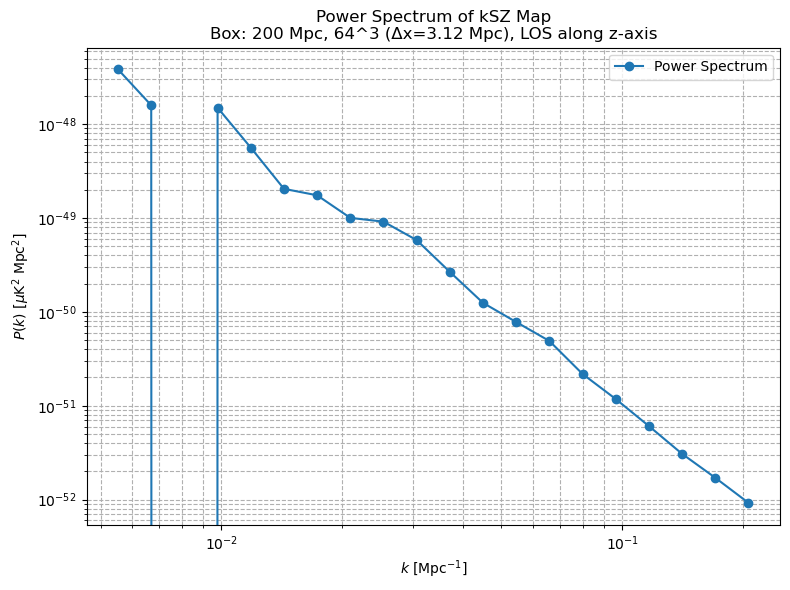

Done. Saved as ksz_power_spectrum.png


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft

# Assume ksz_map is the 64x64 array from the previous cell
N = ksz_map.shape[0]  # 64
box_size = 200.0  # Mpc
pixel_size = box_size / N  # Mpc per pixel

# Compute 2D FFT
ksz_fft = fft.fft2(ksz_map)
ksz_fft_shifted = fft.fftshift(ksz_fft)

# Compute power spectrum (squared magnitude)
power_2d = np.abs(ksz_fft_shifted) ** 2

# Get 2D frequency coordinates, avoiding zero
k_x = fft.fftfreq(N) * N / box_size  # Mpc^-1
k_y = fft.fftfreq(N) * N / box_size  # Mpc^-1
k_x, k_y = np.meshgrid(k_x, k_y)
k_x = fft.fftshift(k_x)
k_y = fft.fftshift(k_y)
k_magnitude = np.sqrt(k_x ** 2 + k_y ** 2)

# Mask out the zero-frequency mode (DC component)
mask = k_magnitude > 0  # Exclude k = 0
k_magnitude = k_magnitude[mask]
power_2d = power_2d[mask]

# Determine k range (excluding zero)
k_min = np.min(k_magnitude)
k_max = np.max(k_magnitude)
if k_min <= 0:
    raise ValueError("Minimum k value is zero or negative after masking. Check frequency grid.")

# Bin the power spectrum
n_bins = 20
k_bins = np.logspace(np.log10(k_min), np.log10(k_max), n_bins + 1)
k_centers = (k_bins[:-1] + k_bins[1:]) / 2

power_binned = np.zeros(n_bins)
for i in range(n_bins):
    mask_bin = (k_magnitude >= k_bins[i]) & (k_magnitude < k_bins[i + 1])
    power_binned[i] = np.mean(power_2d[mask_bin]) if np.any(mask_bin) else 0.0

# Normalize by the number of modes and box volume (2D area)
area = box_size ** 2
power_binned *= (pixel_size ** 2) / area  # Correct for pixel size and area

# Plot
plt.figure(figsize=(8, 6))
plt.loglog(k_centers, power_binned, marker='o', linestyle='-', label='Power Spectrum')
plt.xlabel(r'$k$ [Mpc$^{-1}$]')
plt.ylabel(r'$P(k)$ [$\mu$K$^2$ Mpc$^2$]')
plt.title(f'Power Spectrum of kSZ Map\n{BOX_LABEL}, LOS along z-axis')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.tight_layout()
plt.savefig('ksz_power_spectrum.png', dpi=200)
plt.show()

print("Done. Saved as ksz_power_spectrum.png")

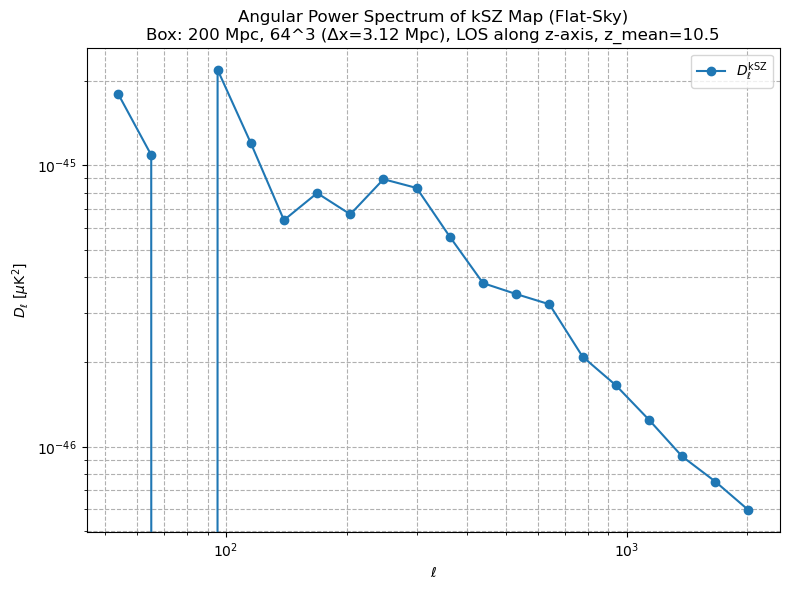

Done. Saved as ksz_Dell_spectrum_flat_sky.png


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft
from astropy.cosmology import Planck18 as cosmo

# Assume ksz_map is the 64x64 array from the previous cell
N = ksz_map.shape[0]  # 64
box_size = 200.0  # Mpc (comoving box size)
pixel_size = box_size / N  # Mpc per pixel

# Compute mean redshift and comoving distance for angular scale
zs_mean = np.mean(ZS)  # Mean redshift (approx 10.5)
chi_mean = cosmo.comoving_distance(zs_mean).value  # Mean comoving distance in Mpc

# Angular size of the box (radians) = box_size / chi_mean
theta_box = box_size / chi_mean  # radians
pixel_theta = theta_box / N  # radians per pixel

# Compute 2D FFT
ksz_fft = fft.fft2(ksz_map)
ksz_fft_shifted = fft.fftshift(ksz_fft)

# Compute power spectrum (squared magnitude)
power_2d = np.abs(ksz_fft_shifted) ** 2 / (N * N)  # Normalize by number of pixels

# Get 2D angular frequency coordinates (ell in radians^-1)
ell_x = fft.fftfreq(N) / pixel_theta  # radians^-1
ell_y = fft.fftfreq(N) / pixel_theta  # radians^-1
ell_x, ell_y = np.meshgrid(ell_x, ell_y)
ell_x = fft.fftshift(ell_x)
ell_y = fft.fftshift(ell_y)
ell_magnitude = np.sqrt(ell_x ** 2 + ell_y ** 2)

# Mask out the zero-frequency mode (DC component)
mask = ell_magnitude > 0  # Exclude ell = 0
ell_magnitude = ell_magnitude[mask]
power_2d = power_2d[mask]

# Determine ell range (excluding zero)
ell_min = np.min(ell_magnitude)
ell_max = np.max(ell_magnitude)
if ell_min <= 0:
    raise ValueError("Minimum ell value is zero or negative after masking. Check frequency grid.")

# Bin the power spectrum
n_bins = 20
ell_bins = np.logspace(np.log10(ell_min), np.log10(ell_max), n_bins + 1)
ell_centers = (ell_bins[:-1] + ell_bins[1:]) / 2

C_ell = np.zeros(n_bins)
for i in range(n_bins):
    mask_bin = (ell_magnitude >= ell_bins[i]) & (ell_magnitude < ell_bins[i + 1])
    C_ell[i] = np.mean(power_2d[mask_bin]) if np.any(mask_bin) else 0.0

# Compute D_ell = ell (ell + 1) C_ell / (2 pi)
D_ell = ell_centers * (ell_centers + 1) * C_ell / (2 * np.pi)

# Plot
plt.figure(figsize=(8, 6))
plt.loglog(ell_centers, D_ell, marker='o', linestyle='-', label=r'$D_\ell^{\rm kSZ}$')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$D_\ell$ [$\mu$K$^2$]')
plt.title(f'Angular Power Spectrum of kSZ Map (Flat-Sky)\n{BOX_LABEL}, LOS along z-axis, z_mean={zs_mean:.1f}')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.tight_layout()
plt.savefig('ksz_Dell_spectrum_flat_sky.png', dpi=200)
plt.show()

print("Done. Saved as ksz_Dell_spectrum_flat_sky.png")

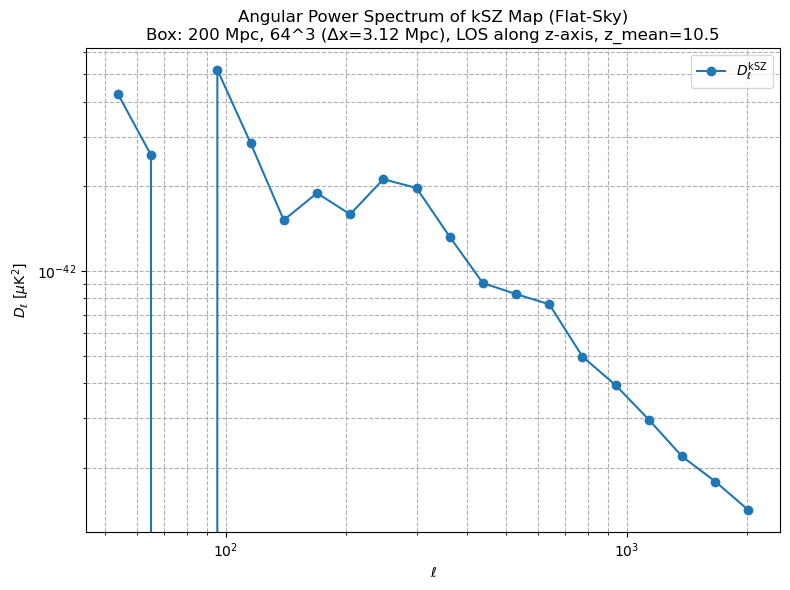

Done. Saved as ksz_Dell_spectrum_flat_sky.png


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft
from astropy.cosmology import Planck18 as cosmo

# Assume ksz_map is the 64x64 array from the previous cell
N = ksz_map.shape[0]  # 64
box_size = 200.0  # Mpc (comoving box size)
pixel_size = box_size / N  # Mpc per pixel

# Compute mean redshift and comoving distance for angular scale
zs_mean = np.mean(ZS)  # Mean redshift (approx 10.5)
chi_mean = cosmo.comoving_distance(zs_mean).value  # Mean comoving distance in Mpc

# Angular size of the box (radians) = box_size / chi_mean
theta_box = box_size / chi_mean  # radians
solid_angle = theta_box ** 2  # steradians
pixel_theta = theta_box / N  # radians per pixel

# Compute 2D FFT
ksz_fft = fft.fft2(ksz_map)
ksz_fft_shifted = fft.fftshift(ksz_fft)

# Compute power spectrum (squared magnitude), normalized by number of modes
power_2d = np.abs(ksz_fft_shifted) ** 2 / (N * N)  # Per mode normalization

# Get 2D angular frequency coordinates (ell in radians^-1)
ell_x = fft.fftfreq(N) / pixel_theta  # radians^-1
ell_y = fft.fftfreq(N) / pixel_theta  # radians^-1
ell_x, ell_y = np.meshgrid(ell_x, ell_y)
ell_x = fft.fftshift(ell_x)
ell_y = fft.fftshift(ell_y)
ell_magnitude = np.sqrt(ell_x ** 2 + ell_y ** 2)

# Mask out the zero-frequency mode (DC component)
mask = ell_magnitude > 0  # Exclude ell = 0
ell_magnitude = ell_magnitude[mask]
power_2d = power_2d[mask]

# Determine ell range (excluding zero)
ell_min = np.min(ell_magnitude)
ell_max = np.max(ell_magnitude)
if ell_min <= 0:
    raise ValueError("Minimum ell value is zero or negative after masking. Check frequency grid.")

# Bin the power spectrum
n_bins = 20
ell_bins = np.logspace(np.log10(ell_min), np.log10(ell_max), n_bins + 1)
ell_centers = (ell_bins[:-1] + ell_bins[1:]) / 2

C_ell = np.zeros(n_bins)
for i in range(n_bins):
    mask_bin = (ell_magnitude >= ell_bins[i]) & (ell_magnitude < ell_bins[i + 1])
    if np.any(mask_bin):
        C_ell[i] = np.mean(power_2d[mask_bin]) / solid_angle  # Normalize by solid angle

# Compute D_ell = ell (ell + 1) C_ell / (2 pi)
D_ell = ell_centers * (ell_centers + 1) * C_ell / (2 * np.pi)

# Plot
plt.figure(figsize=(8, 6))
plt.loglog(ell_centers, D_ell, marker='o', linestyle='-', label=r'$D_\ell^{\rm kSZ}$')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$D_\ell$ [$\mu$K$^2$]')
plt.title(f'Angular Power Spectrum of kSZ Map (Flat-Sky)\n{BOX_LABEL}, LOS along z-axis, z_mean={zs_mean:.1f}')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.tight_layout()
plt.savefig('ksz_Dell_spectrum_flat_sky.png', dpi=200)
plt.show()

print("Done. Saved as ksz_Dell_spectrum_flat_sky.png")